CHOOSING SUBSET(300) FROM CITYSCAPES

In [2]:
import os
from shutil import copy2
import numpy as np
import matplotlib.pyplot as plt

# Base path where the Cityscapes dataset is stored
base_path = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/data/'

# Directories for images and labels
images_dir = os.path.join(base_path, 'leftImg8bit/train/zurich/')
labels_dir = os.path.join(base_path, 'gtFine/train/zurich/')

# Output directories for the subset
subset_images_dir = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/subset/images/'
subset_labels_dir = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/subset/labels/'

# Create directories if they don't exist
os.makedirs(subset_images_dir, exist_ok=True)
os.makedirs(subset_labels_dir, exist_ok=True)


In [3]:
# Number of images to select
num_images = 300

# List all images in the Zurich directory
image_filenames = os.listdir(images_dir)
selected_images = image_filenames[:num_images]  # Select the first 100 images

# Copy selected images and their corresponding labels to the subset directory
for image_filename in selected_images:
    # Construct full paths for source files
    src_image_path = os.path.join(images_dir, image_filename)
    src_label_path = os.path.join(labels_dir, image_filename.replace('leftImg8bit', 'gtFine_labelIds'))

    # Construct destination paths
    dest_image_path = os.path.join(subset_images_dir, image_filename)
    dest_label_path = os.path.join(subset_labels_dir, image_filename.replace('leftImg8bit', 'gtFine_labelIds'))

    # Copy files
    copy2(src_image_path, dest_image_path)
    copy2(src_label_path, dest_label_path)


In [4]:
import sys
sys.path.append('/Users/pranavpolavarapu/DAGAN/DAGAN_v1')

GENERATOR - Attributes definition

In [5]:
from models.networks import define_G


import torch
import argparse
from models.networks.generator import SPADEGenerator
import argparse
from models.networks import define_G

opts = argparse.Namespace()
opts.ngf = 64  # Increase the number of generator filters
opts.z_dim = 256
opts.semantic_nc = 3
opts.num_upsampling_layers = 'normal'
opts.crop_size = 512
opts.aspect_ratio = 1.0
opts.use_vae = False
opts.norm_G = 'spectralspadesyncbatch3x3'
opts.netG = 'spade'  # Ensure this is set correctly as per your model configuration
opts.init_type = 'normal'
opts.init_variance = 0.02
opts.gpu_ids = []  # Use an empty list for CPU mode, specify GPU IDs like [0, 1] for GPU mode


# Assuming 'opts' has been set up with all necessary attributes as previously discussed
generator = define_G(opts)


Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).


In [6]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define the directories containing the subset of images and labels
subset_images_dir = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/subset/images/'
subset_labels_dir = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/subset/labels/'


INPUT SUBSET DATA


In [7]:
class CityscapesSubset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.images = [img for img in os.listdir(images_dir) if img.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.images[index])
        label_path = os.path.join(self.labels_dir, self.images[index].replace('leftImg8bit', 'gtFine_labelIds'))

        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path).convert('L')  # Assuming labels are grayscale

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label


DATA LOADER

In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images for your model
    transforms.ToTensor(),  # Convert images to Tensor
])

# Create an instance of the dataset
dataset = CityscapesSubset(subset_images_dir, subset_labels_dir, transform=transform)

# DataLoader for batching operations
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)


In [9]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


GENERATOR MODEL TRAINING

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import os

# Assuming generator is your model
generator = define_G(opts)
optimizer = optim.Adam(generator.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Determine the appropriate device to use
device = next(generator.parameters()).device

# Ensure the model is on the correct device
generator.to(device)

# Check if a checkpoint exists
if os.path.exists('checkpoint.pth'):
    # Load checkpoint
    checkpoint = torch.load('checkpoint.pth')
    start_epoch = checkpoint['epoch']
    generator.load_state_dict(checkpoint['model_state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0

# Training loop with tqdm progress bar
for epoch in range(start_epoch, 15):
    # Wrap dataloader with tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for inputs, labels in progress_bar:
        # Move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Generate outputs from the model
        outputs = generator(inputs)

        # Resize outputs to match label dimensions and select the correct channel
        outputs_resized = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=False)
        outputs_resized = outputs_resized[:, :1, :, :]  # Ensure output is single-channel if labels are

        # Calculate loss using resized outputs and actual labels
        loss = criterion(outputs_resized, labels)
        loss.backward()
        optimizer.step()

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Save model and optimizer state at the end of each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': generator.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, 'checkpoint.pth')

# Optional: Add a check to ensure no gradients are exploding or vanishing
if torch.isnan(loss) or torch.isinf(loss):
    print("Warning: Invalid loss detected")

In [11]:
import torch
import matplotlib.pyplot as plt
import os

def load_loss_from_checkpoint(path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=torch.device('cpu'))  # Load checkpoint on CPU
        loss = checkpoint['loss']
        if isinstance(loss, torch.Tensor):
            return loss.detach().item()  # Convert tensor to Python float
        else:
            return loss
    else:
        print(f"Checkpoint {path} not found.")
        return None  # Return None if checkpoint is not found

# Specify the paths to the checkpoints
checkpoint_paths_10 = [f'checkpoint_epoch_{i}.pth' for i in range(10, 11)]
checkpoint_paths_15 = [f'checkpoint_epoch_{i}.pth' for i in range(11, 16)]
checkpoint_paths_25 = [f'checkpoint_epoch_{i}.pth' for i in range(16, 26)]

# Load losses from checkpoints
losses_10 = [load_loss_from_checkpoint(path) for path in checkpoint_paths_10]
losses_15 = [load_loss_from_checkpoint(path) for path in checkpoint_paths_15]
losses_25 = [load_loss_from_checkpoint(path) for path in checkpoint_paths_25]

# Remove None values which indicate missing checkpoints
losses_10 = [loss for loss in losses_10 if loss is not None]
losses_15 = [loss for loss in losses_15 if loss is not None]
losses_25 = [loss for loss in losses_25 if loss is not None]

# Check that there are losses to plot, if not, fill with zeros for visualization
if not losses_10:
    losses_10 = [0] * 1  # Just to have a placeholder to show missing data
if not losses_15:
    losses_15 = [0] * 5
if not losses_25:
    losses_25 = [0] * 10

# Plotting the training losses
plt.figure(figsize=(10, 6))
plt.plot(range(10, 11), losses_10, label='Epoch 10', marker='o')
plt.plot(range(11, 16), losses_15, label='Epochs 11-15', marker='o')
plt.plot(range(16, 26), losses_25, label='Epochs 16-25', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


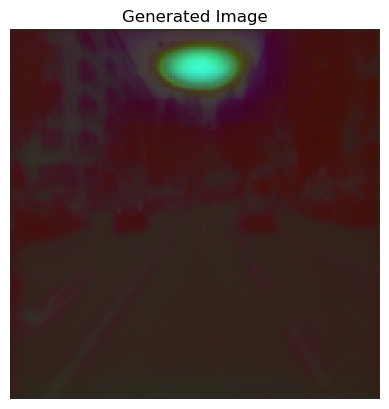

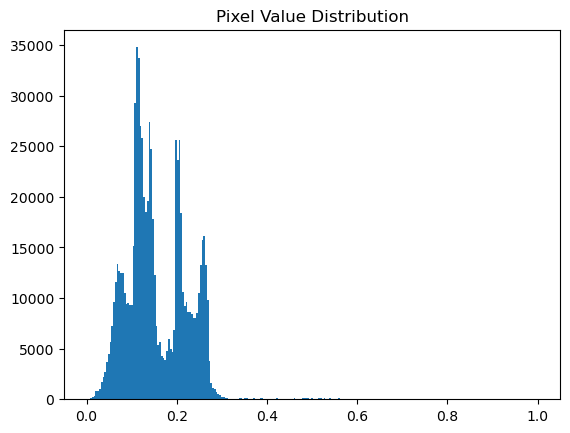

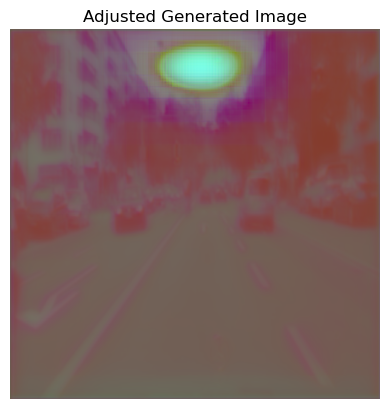

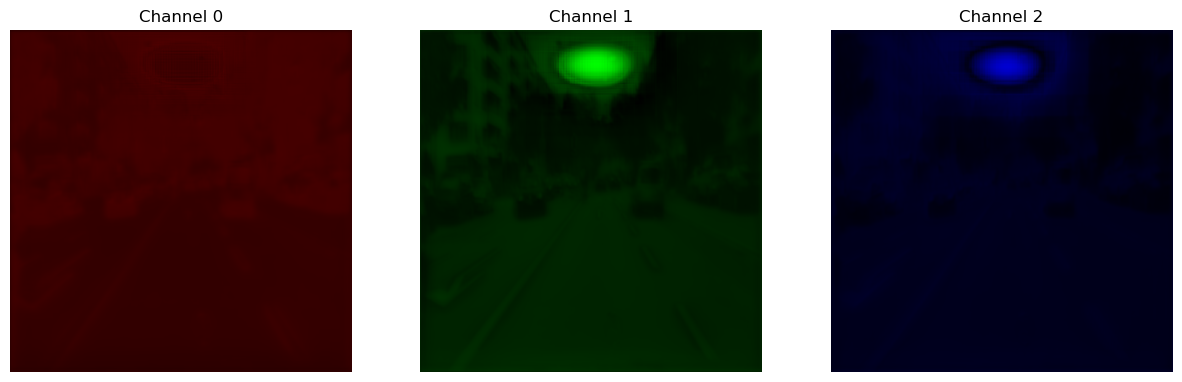

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'outputs' is a tensor with shape [batch_size, channels, height, width]
generated_image = outputs[0]  # Take the first image in the batch

# Normalize the image to [0, 1]
generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

# Move to CPU and convert to numpy
generated_image = generated_image.cpu().detach().permute(1, 2, 0).numpy()

# Display the image
plt.imshow(generated_image)
plt.title('Generated Image')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# If you want to inspect pixel value distribution
plt.hist(generated_image.ravel(), bins=255)
plt.title('Pixel Value Distribution')
plt.show()

# Apply gamma correction
gamma = 0.5  # Adjust this value to see the effect
adjusted_output = np.power(generated_image, gamma)

plt.imshow(adjusted_output)
plt.title('Adjusted Generated Image')
plt.axis('off')
plt.show()

# Plot individual color channels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    channel = np.zeros_like(generated_image)
    channel[:, :, i] = generated_image[:, :, i]
    ax.imshow(channel)
    ax.set_title(f'Channel {i}')
    ax.axis('off')
plt.show()


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set the path for the output directory
output_dir = 'Results/generated_images/'
os.makedirs(output_dir, exist_ok=True)

# Assuming you have a DataLoader named `dataloader` and a model `generator`
generator.eval()  # Set the model to evaluation mode

with torch.no_grad():  # No need to track gradients
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)  # Ensure inputs are on the right device
        outputs = generator(inputs)  # Generate images

        for j in range(inputs.size(0)):  # Iterate through the batch
            # Extract the label and generated images
            label_image = labels[j].cpu().squeeze().numpy()  # Use squeeze() to handle singleton dimensions
            generated_image = outputs[j].cpu().detach().squeeze().numpy()  # Ensure detach() and squeeze() for proper handling

            # Normalize the generated image
            norm_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())
            norm_image = np.transpose(norm_image, (1, 2, 0))  # Reorder to (height, width, channels)

            # Apply gamma correction
            gamma_corrected = np.power(norm_image, 0.5)

            # Plot and save the images
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            
            # Label image subplot
            if label_image.ndim == 2:  # If label image is grayscale
                axs[0].imshow(label_image, cmap='viridis')  # Using a colormap for pseudo-color display
            else:
                axs[0].imshow(np.transpose(label_image, (1, 2, 0)))  # Correcting dimensions if it's not grayscale
            axs[0].axis('off')
            axs[0].set_title('Label Image')

            # Raw generated image subplot
            axs[1].imshow(norm_image)
            axs[1].axis('off')
            axs[1].set_title('Raw Generated Image')

            # Gamma corrected image subplot
            axs[2].imshow(gamma_corrected)
            axs[2].axis('off')
            axs[2].set_title('Gamma Corrected Image')

            # Save the figure
            plt.tight_layout()
            fig.savefig(os.path.join(output_dir, f'image_{i}_{j}.png'))
            plt.close(fig)  # Close the figure to free memory


In [15]:
outputs[0]

tensor([[[ 0.0082,  0.0129,  0.0179,  ...,  0.0159,  0.0179,  0.0136],
         [-0.0112,  0.0050,  0.0074,  ...,  0.0100,  0.0069,  0.0304],
         [ 0.0065,  0.0237,  0.0329,  ...,  0.0293,  0.0228,  0.0326],
         ...,
         [-0.0007,  0.0163,  0.0186,  ...,  0.0168,  0.0145,  0.0271],
         [ 0.0003,  0.0171,  0.0164,  ...,  0.0148,  0.0106,  0.0189],
         [ 0.0163,  0.0290,  0.0276,  ...,  0.0285,  0.0197,  0.0284]],

        [[ 0.0092, -0.0113, -0.0161,  ..., -0.0111, -0.0055, -0.0188],
         [-0.0115, -0.0305, -0.0262,  ..., -0.0200, -0.0060, -0.0214],
         [-0.0187, -0.0353, -0.0379,  ..., -0.0309, -0.0190, -0.0240],
         ...,
         [-0.0051, -0.0215, -0.0183,  ..., -0.0110, -0.0004, -0.0137],
         [-0.0020, -0.0257, -0.0193,  ..., -0.0141, -0.0021, -0.0226],
         [-0.0157, -0.0318, -0.0267,  ..., -0.0249, -0.0146, -0.0212]],

        [[-0.0171, -0.0372, -0.0463,  ..., -0.0457, -0.0391, -0.0145],
         [-0.0394, -0.0514, -0.0484,  ..., -0

In [12]:
import cv2
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import simpledialog

# Load the generated scene image synthesized with DAGAN
scene_image_path = 'subset DATA/hanover_000000_035491_leftImg8bit.png'
if not os.path.exists(scene_image_path):
    print(f"Error: Scene image not found at path: {scene_image_path}")
    exit()
scene_image = cv2.imread(scene_image_path)

# List of weather conditions and corresponding overlay image paths
weather_conditions = ['fog', 'sunny', 'rain', 'snow']
overlay_paths = {
    'fog': 'overlay/fog overlay.jpg',
    'sunny': 'overlay/sunny overlay.jpg',
    'rain': 'overlay/rain overlay.jpg',
    'snow': 'overlay/snow overlay.jpg'
}

# Choose the weather condition
root = Tk()
root.withdraw()  # Hide the main window
weather_condition = simpledialog.askstring("Input", "Enter weather condition (fog, sunny, rain, snow): ",
                                           parent=root)
if weather_condition not in weather_conditions:
    print("Invalid weather condition. Choose from fog, sunny, rain, snow.")
    exit()

# Load the corresponding weather overlay image
overlay_path = overlay_paths.get(weather_condition)
if overlay_path is None or not os.path.exists(overlay_path):
    print(f"Error: Overlay image not found for condition '{weather_condition}'")
    exit()

overlay_image = cv2.imread(overlay_path, cv2.IMREAD_UNCHANGED)

if overlay_image is None:
    print(f"Error loading overlay image from path: {overlay_path}")
    exit()

# Resize overlay image to match the scene image size
if overlay_image.shape[0] != scene_image.shape[0] or overlay_image.shape[1] != scene_image.shape[1]:
    overlay_image = cv2.resize(overlay_image, (scene_image.shape[1], scene_image.shape[0]))

# Blend the scene image and the overlay image
opacity = 0.2  # Adjust the opacity as needed
output_image = cv2.addWeighted(scene_image, 1-opacity, overlay_image, opacity, 0)

# Display the final image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Weather-added Image')
plt.show()


In [ ]:
# Assuming 'outputs' is a tensor with shape [batch_size, channels, height, width]
generated_image = outputs[0]  # Take the first image in the batch

# Normalize the image to [0, 1] if it's not already
if generated_image.max() > 1.0 or generated_image.min() < 0.0:
    generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

# Move to CPU and convert to numpy
generated_image = generated_image.cpu().detach().permute(1, 2, 0).numpy()

# Display the image
plt.imshow(generated_image)
plt.title('Generated Image')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

# Set the path for the output directory
output_dir = 'Results/normOutputs/'
os.makedirs(output_dir, exist_ok=True)

# Assuming you have a DataLoader named `dataloader` and a model `generator`
generator.eval()  # Set the model to evaluation mode

with torch.no_grad():  # No need to track gradients
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)  # Ensure inputs are on the right device
        outputs = generator(inputs)  # Generate images

        for j in range(inputs.size(0)):  # Iterate through the batch
            # Extract the label and generated images
            label_image = labels[j].cpu().squeeze().numpy()  # Use squeeze() to handle singleton dimensions
            generated_image = outputs[j].cpu().detach().squeeze()  # Ensure detach() and squeeze() for proper handling

            # Rescale the output from [-1, 1] to [0, 1] for visualization
            generated_image = (generated_image + 1) / 2.0
            generated_image = torch.clamp(generated_image, 0, 1)
            generated_image_np = generated_image.permute(1, 2, 0).numpy()  # Convert to numpy array and reorder dimensions

            # Enhancements
            # Convert to a format that OpenCV expects, which is uint8 [0, 255]
            generated_image_cv = (generated_image_np * 255).astype(np.uint8)
            # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            for channel in range(3):  # Apply CLAHE to each channel
                generated_image_cv[:, :, channel] = clahe.apply(generated_image_cv[:, :, channel])
            # Color Enhancement
            hsv_image = cv2.cvtColor(generated_image_cv, cv2.COLOR_RGB2HSV)
            hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * 1.5, 0, 255)  # Increase saturation by 50%
            color_enhanced_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
            # Sharpness Enhancement
            gaussian_blur = cv2.GaussianBlur(color_enhanced_image, (0, 0), 3)
            sharpened_image = cv2.addWeighted(color_enhanced_image, 1.5, gaussian_blur, -0.5, 0)
            # Convert back to [0, 1] for visualization
            sharpened_image_np = sharpened_image.astype(np.float32) / 255
            
            # Plot and save the images
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))
            # Label image subplot
            axs[0].imshow(label_image, cmap='viridis')
            axs[0].axis('off')
            axs[0].set_title('Label Image')
            # Enhanced generated image subplot
            axs[1].imshow(sharpened_image_np)
            axs[1].axis('off')
            axs[1].set_title('Enhanced Generated Image')

            # Save the figure
            plt.tight_layout()
            fig.savefig(os.path.join(output_dir, f'image_{i}_{j}.png'))
            plt.close(fig)  # Close the figure to free memory


# UPDATED IMPROVEMENTS
IMPORTS

In [1]:


import os
from shutil import copy2
import numpy as np
import matplotlib.pyplot as plt

# Base path where the Cityscapes dataset is stored
base_path = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/data/'

# Directories for images and labels
images_dir = os.path.join(base_path, 'leftImg8bit/train/zurich/')
labels_dir = os.path.join(base_path, 'gtFine/train/zurich/')

# Output directories for the subset
subset_images_dir = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/subset/images/'
subset_labels_dir = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/subset/labels/'

# Create directories if they don't exist
os.makedirs(subset_images_dir, exist_ok=True)
os.makedirs(subset_labels_dir, exist_ok=True)

# Number of images to select
num_images = 300

# List all images in the Zurich directory
image_filenames = os.listdir(images_dir)
selected_images = image_filenames[:num_images]  # Select the first 100 images

# Copy selected images and their corresponding labels to the subset directory
for image_filename in selected_images:
    # Construct full paths for source files
    src_image_path = os.path.join(images_dir, image_filename)
    src_label_path = os.path.join(labels_dir, image_filename.replace('leftImg8bit', 'gtFine_labelIds'))

    # Construct destination paths
    dest_image_path = os.path.join(subset_images_dir, image_filename)
    dest_label_path = os.path.join(subset_labels_dir, image_filename.replace('leftImg8bit', 'gtFine_labelIds'))

    # Copy files
    copy2(src_image_path, dest_image_path)
    copy2(src_label_path, dest_label_path)

In [2]:
import sys
sys.path.append('/Users/pranavpolavarapu/DAGAN/DAGAN_v1')
from models.networks import define_G


import torch
import argparse
from models.networks.generator import SPADEGenerator
import argparse
from models.networks import define_G

opts = argparse.Namespace()
opts.ngf = 64  # Increase the number of generator filters
opts.z_dim = 256
opts.semantic_nc = 3
opts.num_upsampling_layers = 'normal'
opts.crop_size = 512
opts.aspect_ratio = 1.0
opts.use_vae = False
opts.norm_G = 'spectralspadesyncbatch3x3'
opts.netG = 'spade'  # Ensure this is set correctly as per your model configuration
opts.init_type = 'normal'
opts.init_variance = 0.02
opts.gpu_ids = []  # Use an empty list for CPU mode, specify GPU IDs like [0, 1] for GPU mode


# Assuming 'opts' has been set up with all necessary attributes as previously discussed
generator = define_G(opts)

Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).


Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).
Resuming from epoch 9


Epoch 10: 100%|██████████| 25/25 [38:20<00:00, 92.03s/it, loss=0.000413]


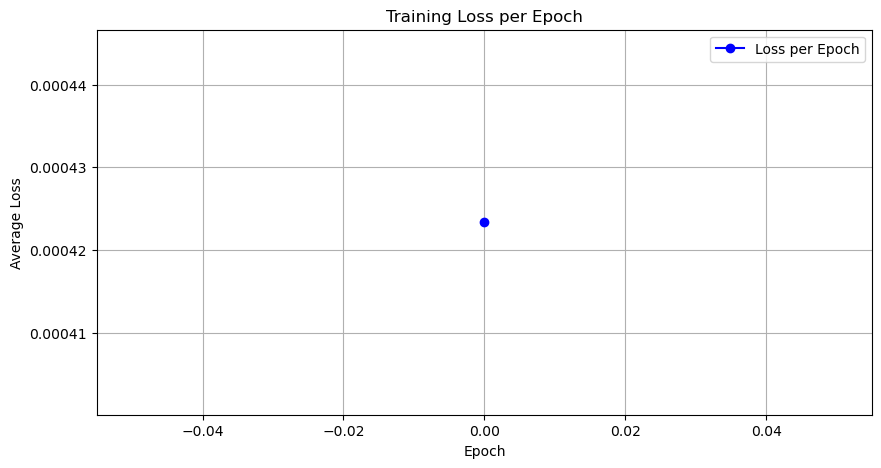

Combined Average Loss Across All Epochs: 0.0004


In [3]:


import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define the directories containing the subset of images and labels
subset_images_dir = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/subset/images/'
subset_labels_dir = '/Users/pranavpolavarapu/Downloads/autonomous/cityscapes/subset/labels/'

class CityscapesSubset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.images = [img for img in os.listdir(images_dir) if img.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.images[index])
        label_path = os.path.join(self.labels_dir, self.images[index].replace('leftImg8bit', 'gtFine_labelIds'))

        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path).convert('L')  # Assuming labels are grayscale

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images for your model
    transforms.ToTensor(),  # Convert images to Tensor
])

# Create an instance of the dataset
dataset = CityscapesSubset(subset_images_dir, subset_labels_dir, transform=transform)

# DataLoader for batching operations
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Assuming generator is your model and it has been defined correctly
generator = define_G(opts)
optimizer = optim.Adam(generator.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Determine the appropriate device to use
device = next(generator.parameters()).device

# Ensure the model is on the correct device
generator.to(device)

# Check if a checkpoint exists
if os.path.exists('checkpoint.pth'):
    # Load checkpoint
    checkpoint = torch.load('checkpoint.pth')
    start_epoch = checkpoint['epoch']
    generator.load_state_dict(checkpoint['model_state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0

# Initialize list to keep track of average losses per epoch
epoch_losses = []

# Training loop with tqdm progress bar
for epoch in range(start_epoch, 10):
    total_loss = 0
    count_batches = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for inputs, labels in progress_bar:
        # Move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients before running the optimizer
        optimizer.zero_grad()

        # Generate outputs from the model
        outputs = generator(inputs)

        # Resize outputs to match label dimensions and select the correct channel
        outputs_resized = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=False)
        outputs_resized = outputs_resized[:, :1, :, :]

        # Calculate loss using resized outputs and actual labels
        loss = criterion(outputs_resized, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count_batches += 1

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Compute average loss for the epoch
    average_loss = total_loss / count_batches
    epoch_losses.append(average_loss)

    # Save model and optimizer state at the end of each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': generator.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, 'checkpoint.pth')

# Optional: Check for exploding or vanishing gradients
if torch.isnan(loss) or torch.isinf(loss):
    print("Warning: Invalid loss detected")

# Calculate the average loss across all epochs
combined_average_loss = sum(epoch_losses) / len(epoch_losses)

# Plotting the epoch losses
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, marker='o', linestyle='-', color='b', label='Loss per Epoch')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

print(f"Combined Average Loss Across All Epochs: {combined_average_loss:.4f}")

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set the path for the output directory
output_dir = 'Results/new_gen_images/'
os.makedirs(output_dir, exist_ok=True)

# Assuming you have a DataLoader named `dataloader` and a model `generator`
generator.eval()  # Set the model to evaluation mode

with torch.no_grad():  # No need to track gradients
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)  # Ensure inputs are on the right device
        outputs = generator(inputs)  # Generate images

        for j in range(inputs.size(0)):  # Iterate through the batch
            # Extract the label and generated images
            label_image = labels[j].cpu().squeeze().numpy()  # Use squeeze() to handle singleton dimensions
            generated_image = outputs[j].cpu().detach().squeeze().numpy()  # Ensure detach() and squeeze() for proper handling

            # Normalize the generated image
            norm_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())
            # Transpose norm_image to have the correct shape
            norm_image = np.transpose(norm_image, (1, 2, 0))

            # Apply gamma correction
            gamma_corrected = np.power(norm_image, 0.5)

            # Plot and save the images
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))

            # Label image subplot
            axs[0].imshow(label_image, cmap='viridis')  # Using a colormap for pseudo-color display
            axs[0].axis('off')
            axs[0].set_title('Label Image')

            # Raw generated image subplot
            axs[1].imshow(norm_image)
            axs[1].axis('off')
            axs[1].set_title('Raw Generated Image')

            # Gamma corrected image subplot
            axs[2].imshow(gamma_corrected)
            axs[2].axis('off')
            axs[2].set_title('Gamma Corrected Image')

            # Save the figure
            plt.tight_layout()
            fig.savefig(os.path.join(output_dir, f'new-gen-image_{i}_{j}.png'))
            plt.close(fig)  # Close the figure to free memory


In [7]:

torch.save({
    'epoch': epoch,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, 'FinalModel.pth')

